In [41]:
import urlparse
import mechanize
from bs4 import BeautifulSoup as Soup
import time
import random
import json
import os
import re
import nltk

In [42]:
#TODO: try outlier detection
# like single class SVM or a mixture model for majority class
# Then a second layer of regression


In [43]:
from nltk import word_tokenize, wordpunct_tokenize
from nltk.stem import *
from nltk.stem.porter import *
from nltk.util import ngrams
from nltk.corpus import stopwords
import numpy as np
import scipy as sp

from sklearn.gaussian_process import GaussianProcess
from time import time
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
import datetime
from sklearn import pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB 

import sys
sys.path.append('/home/tony/code/python/lib/xgboost/wrapper')
sys.path.append('/home/tony/Downloads/hyperopt-sklearn')

from hyperopt import tpe
from hpsklearn import HyperoptEstimator, any_classifier
import xgboost as xgb
from joblib import Parallel, delayed

In [44]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    from operator import itemgetter
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
def get_score_params(grid_scores, n_top=3):
    from operator import itemgetter
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        yield (score.mean_validation_score, score.parameters)

    
 
def print_scoring(y_test, y_pred):
    y_class = np.array([list(x).index(max(x)) for x in y_pred])
    print "classifier final score:    ", multiclass_log_loss(y_test, y_pred)
    print "f1-score: %.3f   accuracy: %.3f   precision: %.3f   recall: %.3f" % (metrics.f1_score(y_test, y_class), 
        metrics.accuracy_score(y_test, y_class), metrics.precision_score(y_test, y_class), metrics.recall_score(y_test, y_class))
    print metrics.classification_report(y_test, y_class)
    
    
def plot_cv_results(grid_search):
    num_figures = len(grid_search.grid_scores_[0][0].keys())

    fig = plt.figure(figsize=(16,4))
    for i in range(num_figures):
        param = grid_search.grid_scores_[0][0].keys()[i]

        ax = fig.add_subplot(1,num_figures, i+1)#, xticks=[], yticks=[])
        
        val = grid_search.grid_scores_[0][0][param]
        if isinstance(val, ( int, float, long, complex )):
            vals = np.array([[x[0][param], x[1]] for x in grid_search.grid_scores_])
        elif isinstance(val, ( bool )):
            vals = np.array([[int(x[0][param]), x[1]] for x in grid_search.grid_scores_])
        elif isinstance(val, ( str )):
            lst = list(set(([x[0][param] for x in grid_search.grid_scores_])))
            vals = np.array([[lst.index(x[0][param]), x[1]] for x in grid_search.grid_scores_])
        #print vals
        vals = vals.T
        
        ax.scatter(vals[0,:], np.abs(vals[1,:]))
        ax.set_xticks(vals[0,:], minor=True)
        plt.xlabel(param)
        plt.ylabel('score')
    
def plot_3d_params(grid_search, label1, label2):
    from mpl_toolkits.mplot3d.axes3d import Axes3D
    all_labels = grid_search.grid_scores_[0][0]
    l1 = [x for x in all_labels.keys() if label1 in x][0]
    l2 = [x for x in all_labels.keys() if label2 in x][0]
    scores = np.array([[x[0][l1], x[0][l2], x[1]] for x in grid_search.grid_scores_])
    x1,x2,x3 = scores[:,0], scores[:,1], np.abs(scores[:,2])
    
    fig1 = plt.figure()
    ax = Axes3D(fig1)

    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_zlabel('score')

    pyplot = ax.scatter(x1,x2,x3)
    plt.show()
    

In [47]:
#Set-up browser
br = mechanize.Browser()
br.set_handle_robots( False )
br.addheaders = [('User-agent', 'Firefox')]
AVG_DELAY_TIME = 0.6

In [48]:
print "loading json files"
with open("papersByYear.json", "r") as infile:
    papersByYear = json.load(infile)  
with open("authorLookup.json", "r") as infile:
    authorLookup = json.load(infile)
    
print "loading training and test papers by year"
with open("papersByYear_train.json", "r") as infile:
    papersByYear_train = json.load(infile)
with open("papersByYear_test.json", "r") as infile:
    papersByYear_test = json.load(infile)
    
print "loading training and test papers"
with open("train_papers.json", "r") as infile:
    train_papers = json.load(infile)
with open("test_papers.json", "r") as infile:
    test_papers = json.load(infile)
    
print "loading author citation data for training and test papers"
with open("authorLookup_train.json", "r") as infile:
    authorLookup_train = json.load(infile)
with open("authorLookup_test.json", "r") as infile:
    authorLookup_test = json.load(infile)

loading json files
loading training and test papers by year
loading training and test papers
loading author citation data for training and test papers


# Downloading papers from the website and save them

In [49]:
def downloadNipsPapersUrls():
    print "loading http://papers.nips.cc"
    response=br.open("http://papers.nips.cc/")
    linksAllYears = [ urlparse.urljoin(l.base_url, l.url) for l in br.links() if 'book' in l.url ]
    print "found links for %d years of papers" % (len(linksAllYears))

    papersByYear = {};
    for linkByYear in linksAllYears:
        year = int(linkByYear[-4:])
        papersByYear[year] = {}
        papersByYear[year]['url'] = linkByYear
        papersByYear[year]['papers'] = {}

        # Don't want to get blacklisted so we'll do some delays
        time.sleep(random.random()*AVG_DELAY_TIME*2)

        response = br.open(linkByYear)
        paperLinks = [ (l.text, urlparse.urljoin(l.base_url, l.url)) for l in br.links() if l.url.startswith('/paper')]
        print "found %d papers for year %d" % (len(paperLinks), year)
        for title, url in paperLinks:
            papersByYear[year]['papers'][title] = {}
            papersByYear[year]['papers'][title]['title'] = title
            papersByYear[year]['papers'][title]['url'] = url
            papersByYear[year]['papers'][title]['pdf'] = url + '.pdf'

    print "all paper urls downloaded!"
    print "writing all page links to json file"
    with open("paperUrlsByYear.json", "w") as outfile:
        json.dump(papersByYear, outfile, indent=4)
  
def downloadPapersAndCreateDirectories():
    print "Creating directories"
    os.mkdir('papers')
    os.chdir('/home/tony/code/python/notebooks/ML_ind_study/papers')
    for year in sorted(papersByYear.keys(), reverse=True):
        print "starting download for year %s" % year
        if not os.path.exists(year):
            os.mkdir(year)
        os.chdir(year)
        papers = [p for p in papersByYear[year]['papers'].values()]
        random.shuffle(papers)
        for i in range(len(papers)):
            paper = papers[i]
            pdf = paper['pdf']
            filename = paper['pdf'].split('/')[-1]

            res = br.retrieve(pdf, filename)
            time.sleep(random.random()*AVG_DELAY_TIME*2)

            #if i in [int(n*len(papers)/20) for n in range(20)]:
            #    print "iter %d/%d\t%.2f percent complete" % (i, len(papers), float(i)/len(papers)*100)
            print "pdf file: %s" % pdf
            print "%d/%d file: %s" % (i, len(papers), filename)

        os.chdir('..')
    os.chdir('..')
    
def loadTextFilesIntoJsonObject():

    # group papers by year into all years
    years = [y for y in papersByYear]
    papersAllYears = { p['title']: p for year in years for p in papersByYear[year]['papers'].values() }

    #save year in json object
    for year in years:
        papers = papersByYear[year]['papers'].values()
        for paper in papers:
            paper['year'] = year
            paper['txt'] = paper['pdf'].split('/')[-1].replace('.pdf', '.txt')

    # read text files into json object
    for paper in papersAllYears.values():
        path = 'papers_txt/%s/%s' % (paper['year'], paper['txt'])
        with open(path, 'r') as in_file:
            paper['text'] = in_file.read()
            paper['short_text'] = re.sub('[ \n\r]', '', paper['text'].lower()).decode('utf8', 'ignore')


    return papersAllYears

    
def downloadHtmlPagesForEachYear():
    print "downloading the html pages for each year"
    for year in papersByYear:
        print "download html page for year %s" % (year)
        papersForYear = papersByYear[year]
        url = papersForYear['url']
        response = br.open(url)
        html_text = response.read()
        papersForYear['html_text'] = html_text 

        #Don't want to get blacklisted so we'll do some delays
        #time.sleep(random.random()*AVG_DELAY_TIME)
        
def findCitationsInDataset(papersByYear):
    years = [y for y in papersByYear]
    papersAllYears = { p['title']: p for year in years for p in papersByYear[year]['papers'].values() }
    titles = [p['title'] for p in sorted(papersAllYears.values(), key=lambda x: int(x['year']))]

    i, N = 0, len(titles)
    for title in titles:
        year = int(papersAllYears[title]['year'])
        if i % 100 == 0:
            print '%d / %d' % (i, N)
        i += 1

        title_mod = re.sub('[ \n\r]', '', title.lower())
        papersAllYears[title]['citations'] = []
        # find who is citing this paper
        other_papers = [p for p in papersAllYears.values() if p['title'] != title and int(p['year']) >= year]
        for paper in other_papers:
            if title_mod in paper['short_text']:
                #Have to check for authors too
                authors = paper["authors"]
                names_str = ' '.join([x['name'] for x in authors])
                names = names_str.split(' ')
                found_it = False
                for name in names:
                    if name in paper['short_text']:
                        papersAllYears[title]['citations'].append(paper['title'])
                        found_it = True
                        break
                    
                if not found_it:
                    print 'found title [%s] in the paper [%s], however no authors were found: [%s]' % (title, paper['title'], names_str)
                        
                #print '%s - %s [cited] %s - %s' % (paper['title'], paper['year'], title, papersAllYears[title]['year'])

    for paper in papersAllYears.values():
        paper['num_citations'] = len(paper['citations'])
        
def extractAuthorsFromHtmlpages(papersByYear):
    authorLookup = {}
    for year in list(papersByYear):
        print "getting authors for year %s" % (year)
        papersForYear = papersByYear[year]
        papers = papersForYear['papers']
        html = papersForYear['html_text']
        soup = Soup(html)
        for title in list(papers):
            paper = papers[title]
            paperUrl = paper['url']
            paperHref = paperUrl.split('/')[-1]
            #paperLink = Soup.select(soup, 'a[href*="%s"]' % paperHref)
            authorLinks = soup.findAll(href = re.compile(paperHref))[0].parent.findAll('a', 'author')           
            paper['authors'] = map(lambda x: {'rawName': x.contents[0], 
                                              'id': x['href'], 
                                              'name': x.contents[0].split(' ')[0] + ' ' + 
                                                      x.contents[0].split(' ')[-1]}, authorLinks)
            for author in paper['authors']:
                authorId = author['id']
                rawName  = author['rawName']
                num_authors = len(paper['authors'])
                otherAuthors = map(lambda x: x['id'], paper['authors'])
                otherAuthors.remove(authorId)

                if authorId not in authorLookup:
                    authorLookup[authorId] = {'titles': [], 'names': [], 'coauthors': [], 'num_citations': 0, 
                                              'citations_per_author': 0, 'all_citation_counts': [] }
                    
                authorLookup[authorId]['titles'].append(title)
                authorLookup[authorId]['names'].append(rawName)
                authorLookup[authorId]['coauthors'] += otherAuthors
                if 'num_citations' in paper:
                    authorLookup[authorId]['num_citations'] += paper['num_citations']
                    authorLookup[authorId]['citations_per_author'] += paper['num_citations'] / float(num_authors)
                    authorLookup[authorId]['all_citation_counts'].append(paper['num_citations'])
                    
    return authorLookup


def extractAuthorsFromHtmlpagesNoCitations(papersByYear):
    for year in list(papersByYear):
        print "getting authors for year %s" % (year)
        papersForYear = papersByYear[year]
        papers = papersForYear['papers']
        html = papersForYear['html_text']
        soup = Soup(html)
        for title in list(papers):
            paper = papers[title]
            paperUrl = paper['url']
            paperHref = paperUrl.split('/')[-1]
            #paperLink = Soup.select(soup, 'a[href*="%s"]' % paperHref)
            authorLinks = soup.findAll(href = re.compile(paperHref))[0].parent.findAll('a', 'author')           
            paper['authors'] = map(lambda x: {'rawName': x.contents[0], 
                                              'id': x['href'], 
                                              'name': x.contents[0].split(' ')[0] + ' ' + 
                                                      x.contents[0].split(' ')[-1]}, authorLinks)
def createAuthorLookup(papersByYear):
    authorLookup = {}
    for year in list(papersByYear):
        papers = papersByYear[year]['papers']
        for title in list(papers):
            paper = papers[title]
            for author in paper['authors']:
                authorId = author['id']
                rawName  = author['rawName']
                num_authors = len(paper['authors'])
                otherAuthors = [x['id'] for x in paper['authors'] if x['id'] != authorId]

                if authorId not in authorLookup:
                    authorLookup[authorId] = {'titles': [], 'names': [], 'coauthors': [], 'num_citations': 0, 
                                              'citations_per_author': 0, 'all_citation_counts': [] }
                    
                authorLookup[authorId]['titles'].append(title)
                authorLookup[authorId]['names'].append(rawName)
                authorLookup[authorId]['coauthors'] += otherAuthors
                if 'num_citations' in paper:
                    authorLookup[authorId]['num_citations'] += paper['num_citations']
                    authorLookup[authorId]['citations_per_author'] += paper['num_citations'] / float(num_authors)
                    authorLookup[authorId]['all_citation_counts'].append(paper['num_citations'])
                     
    return authorLookup

def getAuthorCitationsFeatures(papersByYear, authorLookup):
    for author in authorLookup.values():
        citations_sum = author['num_citations']
        all_citations_counts = [n for n in author['all_citation_counts']]
        if not all_citations_counts:
            author['citations_log_sum'] = 0
            author['citations_log_mean'] = 0
            author['citations_log_max'] = 0
            author['citations_h_index'] = 0
            author['citations_g_index'] = 0
        else:
            author['citations_log_sum'] = sp.log2(citations_sum+1)
            author['citations_log_mean'] = sp.log2(( citations_sum/float(len(all_citations_counts)) ) + 1)
            author['citations_log_max'] = sp.log2(max(all_citations_counts)+1)
            author['citations_h_index'] = calc_h_index(all_citations_counts)
            author['citations_g_index'] = calc_g_index(all_citations_counts)
        
    # get co-author average citations
    for author in authorLookup.values():
        coauthorIds = author['coauthors']
        coauthor_all_citations_counts = [authorLookup[cId]['num_citations'] for cId in coauthorIds]
        coauthor_all_citations_counts = [n for n in coauthor_all_citations_counts]
        coauthors_with_publications = float(len([n for n in coauthor_all_citations_counts if n > 0]))
        coauthor_citations_sum = sum(coauthor_all_citations_counts)
        if not coauthor_all_citations_counts:
            author['coauthor_citations_log_sum'] = 0
            author['coauthor_citations_log_mean'] = 0
            author['coauthor_citations_log_max'] = 0
            author['coauthor_citations_h_index'] = 0
            author['coauthor_citations_g_index'] = 0  
            author['coauthors_with_publications'] = 0
            author['percent_coauthors_with_publications'] = 0
        else:
            author['coauthor_citations_log_sum'] = sp.log2(coauthor_citations_sum+1)
            author['coauthor_citations_log_mean'] = sp.log2(( coauthor_citations_sum/float(len(coauthor_all_citations_counts)) ) + 1)
            author['coauthor_citations_log_max'] = sp.log2(max(coauthor_all_citations_counts)+1)
            author['coauthor_citations_h_index'] = calc_h_index(coauthor_all_citations_counts)
            author['coauthor_citations_g_index'] = calc_g_index(coauthor_all_citations_counts)
            author['coauthors_with_publications'] = coauthors_with_publications
            author['percent_coauthors_with_publications'] = coauthors_with_publications/len(coauthor_all_citations_counts)

def findPapersWithAuthorsInThem(papersByYear, authorLookup):
    years = [y for y in papersByYear]
    papersAllYears = { p['title']: p for year in years for p in papersByYear[year]['papers'].values() }
    titles = [p['title'] for p in sorted(papersAllYears.values(), key=lambda x: int(x['year']))]

    for title in titles:

        title_mod = re.sub('[ \n\r]', '', title.lower())
        papersAllYears[title]['citations'] = []
        # find who is citing this paper
        for paper in [p for p in papersAllYears.values() if p['title'] != title]:
            if title_mod in paper['short_text']:
                papersAllYears[title]['citations'].append(paper['title'])
                #print '%s - %s [cited] %s - %s' % (paper['title'], paper['year'], title, papersAllYears[title]['year'])

    for paper in papersAllYears.values():
        paper['num_citations'] = len(paper['citations'])
           
            
#max h s.t. at least h papers by the entity received at least h citations
def calc_h_index(counts):
    if not counts:
        return 0

    counts = sorted(counts, reverse=True)
    for k in range(len(counts)):
        if k+1 > counts[k]:
            return k
    return len(counts)
        
#max g s.t. the top g papers by the entity received together at least g^2 citations
def calc_g_index(counts):
    if not counts:
        return 0

    counts = sorted(counts, reverse=True)
    sum_count = 0
    for k in range(len(counts)):
        sum_count += counts[k]
        g = k+1
        if sum_count < g*g:
            return g-1
        
    return len(counts)
    
def getPapersAllYears(papersByYear):
    years = [year for year in papersByYear]
    return { p['title']: p for year in years for p in papersByYear[year]['papers'].values() }

needToSaveObjects = False

needToDownloadPapersUrlsFromNips = False
needToDownloadPapersAndCreateDirectories = False
needToDownloadHtmlPagesForEachYear = False
needToLoadTextFilesIntoJsonObject = False
needToExtractAuthorsFromHtmlpages = False
needToFindCitationsInDataset = False
needToCreateAuthorCitationLookup = False
needToExtractAuthorCitationsCounts = False
    
if needToDownloadPapersUrlsFromNips:
    downloadNipsPapersUrls()
        
if needToDownloadPapersAndCreateDirectories:
    downloadPapersAndCreateDirectories()
    
if needToDownloadHtmlPagesForEachYear:
    downloadHtmlPagesForEachYear()
            
if needToLoadTextFilesIntoJsonObject:
    loadTextFilesIntoJsonObject()

if needToExtractAuthorsFromHtmlpages:
    extractAuthorsFromHtmlpages(papersByYear)
    
if needToFindCitationsInDataset:
    findCitationsInDataset(papersByYear)
    
#if needToCreateAuthorCitationLookup:
#    authorLookup = createAuthorLookup(papersByYear)
    
if needToExtractAuthorCitationsCounts:
    getAuthorCitationsFeatures(papersByYear, authorLookup)

    
if needToSaveObjects:
    print "saving papersByYear"
    with open("papersByYear.json", "w") as outfile:
            json.dump(papersByYear, outfile, indent=4)

    #with open("papersAllYears.json", "w") as outfile:
    #        json.dump(papersAllYears, outfile, indent=4)
            
    print "saving authorLookup"
    with open("authorLookup.json", "w") as outfile:
        json.dump(authorLookup, outfile, indent=4)
        

# Unit-tests

In [50]:
print "Testing H-Index calculation"

tests = {2: [1, 2, 1, 3], 1: [1, 9, 1, 1], 3: [9, 4, 1, 3], 4: [9, 4, 5, 8, 1], 0: [0, 0, 0]}
for ans in tests:
    res = calc_h_index(tests[ans])
    print "actual:", res, "expected:", ans, "data:", ','.join(map(lambda x: str(x), sorted(tests[ans], reverse=True)))
    
    
print "Testing G-Index calculation"

tests = {0: [0, 0], 1: [1, 2, 1, 1], 2: [1, 3, 2, 1], 3: [2, 3, 4, 1], 4: [5, 3, 3, 6]}
for ans in tests:
    res = calc_g_index(tests[ans])
    print "actual:", res, "expected:", ans, "data:", ','.join(map(lambda x: str(x), sorted(tests[ans], reverse=True)))  

Testing H-Index calculation
actual: 0 expected: 0 data: 0,0,0
actual: 1 expected: 1 data: 9,1,1,1
actual: 2 expected: 2 data: 3,2,1,1
actual: 3 expected: 3 data: 9,4,3,1
actual: 4 expected: 4 data: 9,8,5,4,1
Testing G-Index calculation
actual: 0 expected: 0 data: 0,0
actual: 1 expected: 1 data: 2,1,1,1
actual: 2 expected: 2 data: 3,2,1,1
actual: 3 expected: 3 data: 4,3,2,1
actual: 4 expected: 4 data: 6,5,3,3


# Creating training data

In [51]:
def splitPapers(papersByYear):
    print "spliting papers into training and test set"
    papersByYear_train, papersByYear_test = {}, {}
    percent_test = 0.3
    for year in papersByYear:
        print "there are", len(papersByYear[year]['papers'].values()), "papers for year", year
        papersByYear_train[year] = {}
        papersByYear_train[year]['papers'] = {}
        papersByYear_train[year]['html_text'] = papersByYear[year]['html_text']

        papersByYear_test[year] = {}
        papersByYear_test[year]['papers'] = {}
        papersByYear_test[year]['html_text'] = papersByYear[year]['html_text']

        papersForYear = papersByYear[year]['papers']
        for title in papersForYear:
            if random.random() < percent_test:
                papersByYear_test[year]['papers'][title]  = papersByYear[year]['papers'][title]
            else:
                papersByYear_train[year]['papers'][title] = papersByYear[year]['papers'][title]
                
    return papersByYear_train, papersByYear_test


if False:
    papersByYear_train, papersByYear_test = splitPapers(papersByYear)

if False:
    for year in papersByYear:
        papersByYear_train[year]['html_text'] = papersByYear[year]['html_text']
        papersByYear_test[year]['html_text']  = papersByYear[year]['html_text']
    
if False:
    print "get citations for each list"
    findCitationsInDataset(papersByYear_train)
    findCitationsInDataset(papersByYear_test)

if False:
    print "get author lookups"
    authorLookup_train = extractAuthorsFromHtmlpages(papersByYear_train)
    authorLookup_test = extractAuthorsFromHtmlpages(papersByYear_test)

if False:
    print "get authors citation features"
    getAuthorCitationsFeatures(papersByYear_train, authorLookup_train)
    getAuthorCitationsFeatures(papersByYear_test, authorLookup_test)

if False:
    train_papers = getPapersAllYears(papersByYear_train)
    test_papers = getPapersAllYears(papersByYear_test)
    
if False:
    print "saving train and test data"
    
    with open("papersByYear_train.json", "w") as outfile:
        json.dump(papersByYear_train, outfile, indent=4)
        
    with open("papersByYear_test.json", "w") as outfile:
        json.dump(papersByYear_test, outfile, indent=4)
        
    with open("train_papers.json", "w") as outfile:
        json.dump(train_papers, outfile, indent=4)
        
    with open("test_papers.json", "w") as outfile:
        json.dump(test_papers, outfile, indent=4)
        
    with open("authorLookup_train.json", "w") as outfile:
        json.dump(authorLookup_train, outfile, indent=4)
        
    with open("authorLookup_test.json", "w") as outfile:
        json.dump(authorLookup_test, outfile, indent=4)
        

# Generating the data sets for machine learning

In [52]:
num_training_papers = len(train_papers)
num_test_papers = len(test_papers)
num_training_authors = len(authorLookup_train)
num_test_authors = len(authorLookup_test)

train_authors = {t[0]: t[1] for t in zip(list(authorLookup_train), range(num_training_authors))}
                                                # Don't keep the authors we don't have any info about
                                                # (we can use the citation/coauthor network to get info so we
                                                #  don't have to throw away these examples)
test_authors = {t[0]: t[1] for t in zip(list(authorLookup_test), range(num_test_authors)) if t[0] in train_authors}
#test_authors = {t[0]: t[1] for t in zip(list(authorLookup_test), range(num_test_authors))}

X_train = np.zeros((num_training_papers, num_training_authors))
X_test = np.zeros((num_test_papers, num_training_authors))
y_train = np.zeros((num_training_papers))
y_test = np.zeros((num_test_papers))

for k in range(num_training_papers):
    author_indexes = map(lambda x: train_authors[x['id']], train_papers.values()[k]['authors'])
    X_train[k, author_indexes] = 1
    y_train[k] = train_papers.values()[k]['num_citations']
    
for k in range(num_test_papers):
    author_ids = [x['id'] for x in  test_papers.values()[k]['authors']]
    author_indexes = [train_authors[x] for x in author_ids if x in train_authors ]
    X_test[k, author_indexes] = 1
    y_test[k] = test_papers.values()[k]['num_citations']

In [54]:
print "generating the citation_features matrices per author"

author_features = np.zeros((num_training_authors, 12))
for k in range(num_training_authors):
    author_features[k,0]  = authorLookup_train.values()[k]['num_citations']
    author_features[k,1]  = authorLookup_train.values()[k]['citations_per_author']
    author_features[k,2]  = authorLookup_train.values()[k]['citations_log_max']
    author_features[k,3]  = authorLookup_train.values()[k]['citations_log_sum']
    author_features[k,4]  = authorLookup_train.values()[k]['citations_log_mean']
    author_features[k,5]  = authorLookup_train.values()[k]['citations_g_index']
    author_features[k,6]  = authorLookup_train.values()[k]['citations_h_index']
    author_features[k,7]  = authorLookup_train.values()[k]['coauthor_citations_log_max']
    author_features[k,8]  = authorLookup_train.values()[k]['coauthor_citations_log_sum']
    author_features[k,9]  = authorLookup_train.values()[k]['coauthor_citations_log_mean']
    author_features[k,10] = authorLookup_train.values()[k]['coauthor_citations_g_index']
    author_features[k,11] = authorLookup_train.values()[k]['coauthor_citations_h_index']
    #author_features[k,12] = authorLookup_train.values()[k]['coauthors_with_publications']
    #author_features[k,13] = authorLookup_train.values()[k]['percent_coauthors_with_publications']
#max h s.t. at least 

generating the citation_features matrices per author


In [55]:
X_train_features = np.dot(X_train, author_features)
X_test_features = np.dot(X_test, author_features)

#Training Classifiers

In [12]:
#clf = LinearRegression()
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#y_pred = y_pred.clip(min=0, max=20)

In [28]:
lr = LinearRegression()
lr.fit(X_train_features, y_train)
y_pred_lr = lr.predict(X_test_features)

In [29]:
svr = SVR()
svr.fit(X_train_features, y_train)
y_pred_svr = svr.predict(X_test_features)

In [30]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=6, compute_importances=True)
rf.fit(X_train_features, y_train)
y_pred_rf = rf.predict(X_test_features)
print "citation feature matrix with lr mean sqr error:", mean_squared_error(y_test, y_pred_rf), "r2:", r2_score(y_test, y_pred_rf)

citation feature matrix with lr mean sqr error: 18.408455387 r2: -0.0748326010436


/home/tony/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:923: DeprecationWarning: Setting compute_importances is no longer required as version 0.14. Variable importances are now computed on the fly when accessing the feature_importances_ attribute. This parameter will be removed in 0.16.
  DeprecationWarning)


In [31]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train_features, y_train)
y_pred_gbm = gbm.predict(X_test_features);

# Feature Importances

In [ ]:
vals = rf.feature_importances_
labels = ['num_citations', 'citations_per_author', 'citations_log_max', 'citations_log_sum',
           'citations_log_mean', 'citations_g_index', 'citations_h_index', 'coauthor_citations_log_max',
           'coauthor_citations_log_sum', 'coauthor_citations_log_mean', 'coauthor_citations_g_index', 
           'coauthor_citations_h_index']

N = len( labels )

plt.figure(figsize=(10,8))
pos = [n+.5 for n in range(N)]   
plt.barh(pos, vals, align='center')
plt.yticks(pos, labels)
plt.xlabel('Importance')
plt.title('Feature importances')

plt.show()

In [78]:
print "lr:", np.min(y_pred_lr), np.max(y_pred_lr), np.mean(np.abs(y_pred_lr - y_test)), r2_score(y_test, y_pred_lr)
print "rf:", np.min(y_pred_rf), np.max(y_pred_rf), np.mean(np.abs(y_pred_rf - y_test)), r2_score(y_test, y_pred_rf)
print "svc:", np.min(y_pred_svr), np.max(y_pred_svr), np.mean(np.abs(y_pred_svr - y_test)), r2_score(y_test, y_pred_svr)
print "gbm:", np.min(y_pred_gbm), np.max(y_pred_gbm), np.mean(np.abs(y_pred_gbm - y_test)), r2_score(y_test, y_pred_gbm)
print "zeros", 0, 0, np.mean(np.abs(np.zeros_like(y_test) - y_test)), r2_score(y_test, np.zeros_like(y_test))
y_pred_all = (y_pred_lr + y_pred_rf + y_pred_svr + y_pred_gbm)/4
print "all:", np.min(y_pred_all), np.max(y_pred_all), np.mean(np.abs(y_pred_all - y_test)), r2_score(y_test, y_pred_all)
print "actual:", np.min(y_test), np.max(y_test)

lr: -0.165622720028 2.4114075664 0.789445839467 0.00901262602923
rf: 0.0 102.43 0.389818531734 0.822415254955
svc: -0.100081252444 2.48803012158 0.453342344683 0.0263335484322
gbm: -1.22535984219 137.969095491 0.508977066921 0.944809856778
zeros 0 0 0.546658639374 -0.0174484122416
all: 0.0110159087083 60.5449263346 0.527361738882 0.599668498995
actual: 0.0 160.0


In [40]:
for k in range(21):
    y_pred_gbm_clipped = np.clip(y_pred_gbm, 0, k)
    print "gbm score for clip 0-%d: mean: %.3f, r2: %.3f" % (k, np.mean(np.abs(y_pred_gbm_clipped - y_test)), r2_score(y_test, y_pred_gbm_clipped))

print "gbm score with no clip: mean: %.3f, r2: %.3f" % (np.mean(np.abs(y_pred_gbm - y_test)), r2_score(y_test, y_pred_gbm))
print "zeros:", np.mean(np.abs(np.zeros_like(y_test) - y_test)), r2_score(y_test, np.zeros_like(y_test))

gbm score for clip 0-0: mean: 0.547, r2: -0.017
gbm score for clip 0-1: mean: 0.710, r2: -0.002
gbm score for clip 0-2: mean: 0.806, r2: -0.008
gbm score for clip 0-3: mean: 0.860, r2: -0.018
gbm score for clip 0-4: mean: 0.889, r2: -0.025
gbm score for clip 0-5: mean: 0.907, r2: -0.031
gbm score for clip 0-6: mean: 0.919, r2: -0.036
gbm score for clip 0-7: mean: 0.926, r2: -0.041
gbm score for clip 0-8: mean: 0.929, r2: -0.043
gbm score for clip 0-9: mean: 0.932, r2: -0.046
gbm score for clip 0-10: mean: 0.934, r2: -0.047
gbm score for clip 0-11: mean: 0.934, r2: -0.048
gbm score for clip 0-12: mean: 0.935, r2: -0.048
gbm score for clip 0-13: mean: 0.935, r2: -0.048
gbm score for clip 0-14: mean: 0.935, r2: -0.048
gbm score for clip 0-15: mean: 0.935, r2: -0.048
gbm score for clip 0-16: mean: 0.935, r2: -0.048
gbm score for clip 0-17: mean: 0.935, r2: -0.048
gbm score for clip 0-18: mean: 0.935, r2: -0.048
gbm score for clip 0-19: mean: 0.935, r2: -0.048
gbm score for clip 0-20: mean:

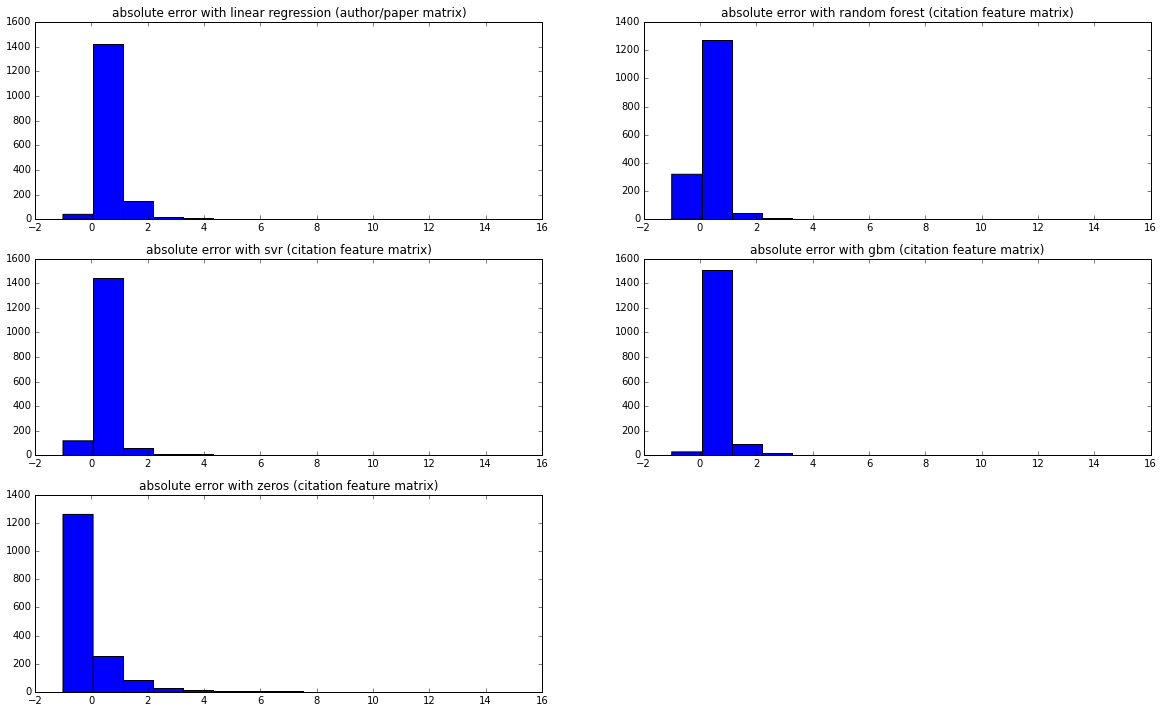

In [34]:
plt.figure(figsize=(20,12))
plt.subplot(3,2,1)
plt.hist(np.abs(y_pred_lr - y_test), bins=np.linspace(-1,15,16))
plt.title('absolute error with linear regression (author/paper matrix)')
plt.subplot(3,2,2)
plt.hist(np.abs(y_pred_rf - y_test), bins=np.linspace(-1,15,16))
plt.title('absolute error with random forest (citation feature matrix)')
plt.subplot(3,2,3)
plt.hist(np.abs(y_pred_svr - y_test), bins=np.linspace(-1,15,16))
plt.title('absolute error with svr (citation feature matrix)')
plt.subplot(3,2,4)
plt.hist(np.abs(y_pred_gbm - y_test), bins=np.linspace(-1,15,16))
plt.title('absolute error with gbm (citation feature matrix)')
plt.subplot(3,2,5)
plt.hist(np.abs(np.zeros_like(y_pred_gbm) - y_test), bins=np.linspace(-1,15,16))
plt.title('absolute error with zeros (citation feature matrix)')

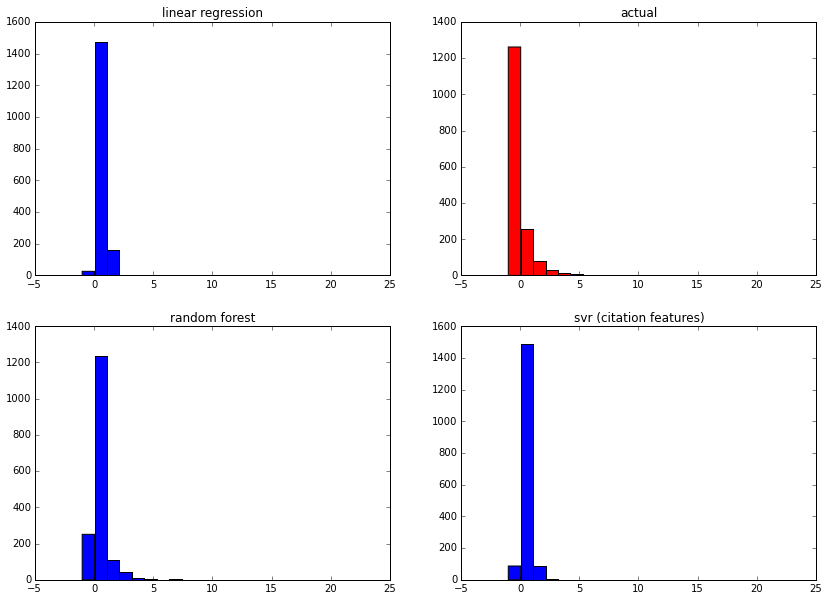

In [35]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.hist(y_pred_lr, color='blue', bins=np.linspace(-1,20,21))
plt.title('linear regression')
plt.subplot(2,2,2)
plt.hist(y_test, color='red', bins=np.linspace(-1,20,21))
plt.title('actual')

plt.subplot(2,2,3)
plt.hist(y_pred_rf, color='blue', bins=np.linspace(-1,20,21))
plt.title('random forest')
plt.subplot(2,2,4)
plt.hist(y_pred_svr, color='blue', bins=np.linspace(-1,20,21))
plt.title('svr (citation features)')

#Plotting citation counts

In [99]:
years = [year for year in papersByYear]
papersAllYears = getPapersAllYears(papersByYear)
print(len(papersAllYears))*0.02
morethatten = len([x['num_citations'] for x in papersAllYears.values() if x['num_citations'] > 10])
print morethatten
z = np.array([1,2,3,4,5,6])
np.dot(z, z2)
print len([x['num_citations'] for x in papersAllYears.values() if x['num_citations'] > 10])/float(len(papersAllYears))

111.8
118
0.0211091234347


distribution of citations over the dataset


[-1, 100, -1, 3929]

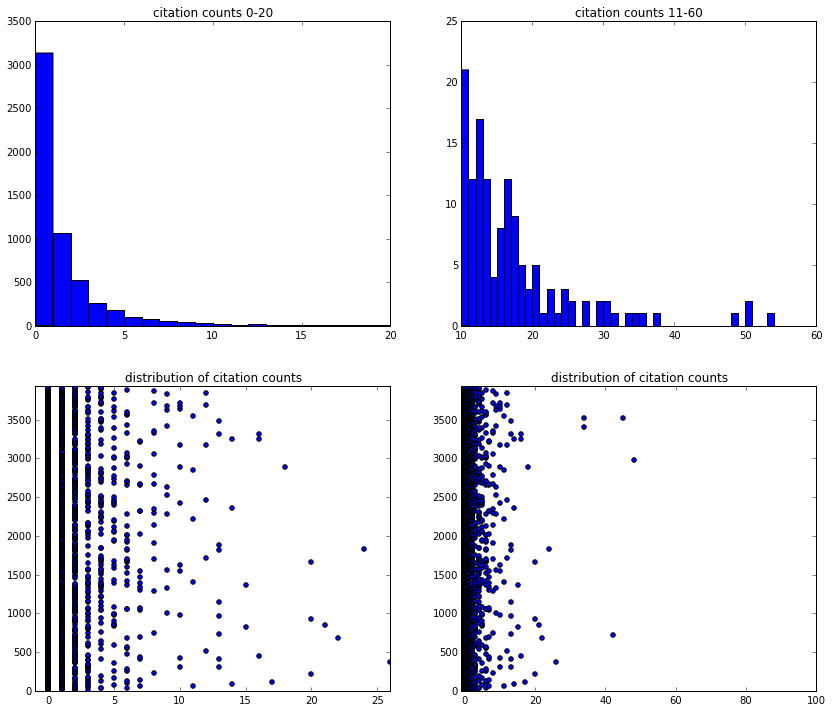

In [46]:
print 'distribution of citations over the dataset'

years = [year for year in papersByYear]
papersAllYearsWithCitations = getPapersAllYears(papersByYear)
counts = [paper['num_citations'] for paper in papersAllYearsWithCitations.values()]
counts = [n for n in counts if n <= 60]

plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
plt.hist(counts, bins=np.linspace(0,20,21))
plt.title('citation counts 0-20')
#plt.yscale('log')

plt.subplot(2,2,2)
plt.hist(counts, bins=np.linspace(10,60,51))
plt.title('citation counts 11-60')

plt.subplot(2,2,3)
plt.scatter(y_train, range(len(y_train)))
plt.title('distribution of citation counts')
plt.axis([-1, 26, -1, len(y_train)])

plt.subplot(2,2,4)
plt.scatter(y_train, range(len(y_train)))
plt.title('distribution of citation counts')
plt.axis([-1, 100, -1, len(y_train)])

#papers_ordered_by_counts = sorted(papersAllYearsWithCitations.values(), key=lambda x: x['num_citations'], reverse=True)

/home/tony/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:611: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc5fd8edd50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle))
/home/tony/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:611: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc5fd8bcd10>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle))
/home/tony/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:611: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc5fd78e350>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle))
/home/tony/anaconda/li

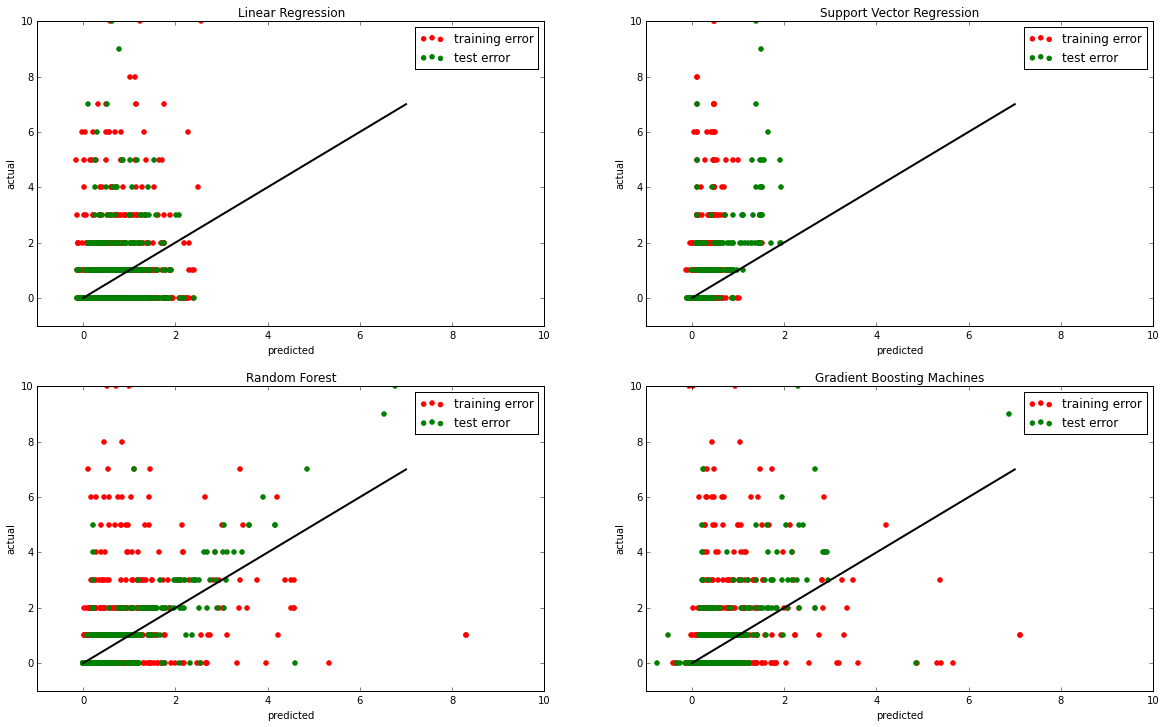

In [63]:
labels = [
    'num_citations',
    'citations_per_author',
    'citations_log_max',
    'citations_log_sum',
    'citations_log_mean',
    'citations_g_index',
    'citations_h_index',
    'coauthor_citations_log_max',
    'coauthor_citations_log_sum',
    'coauthor_citations_log_mean',
    'coauthor_citations_g_index',
    'coauthor_citations_h_index'
]

models = [lr, svr, rf, gbm]
model_labels = ['Linear Regression', 'Support Vector Regression', 'Random Forest', 'Gradient Boosting Machines']
fig = plt.figure(figsize=(20,12))
for k in range(4):
    ax = fig.add_subplot(2, 2, k+1)
    p1 = plt.scatter(models[k].predict(X_train_features[:1000]), y_train[:1000], color='red')
    p2 = plt.scatter(models[k].predict(X_test_features[:1000]), y_test[:1000], color='green')
    p3 = plt.plot(range(8), range(8), linewidth=2, color='black')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(model_labels[k])
    plt.axis([-1, 10, -1, 10])
    plt.legend([p1, p2, p3], ['training error','test error', 'perfect'])
    #np.sum(X_test_features[:,0] == X_test_features[:,k])/float(X_test_features.shape[0])


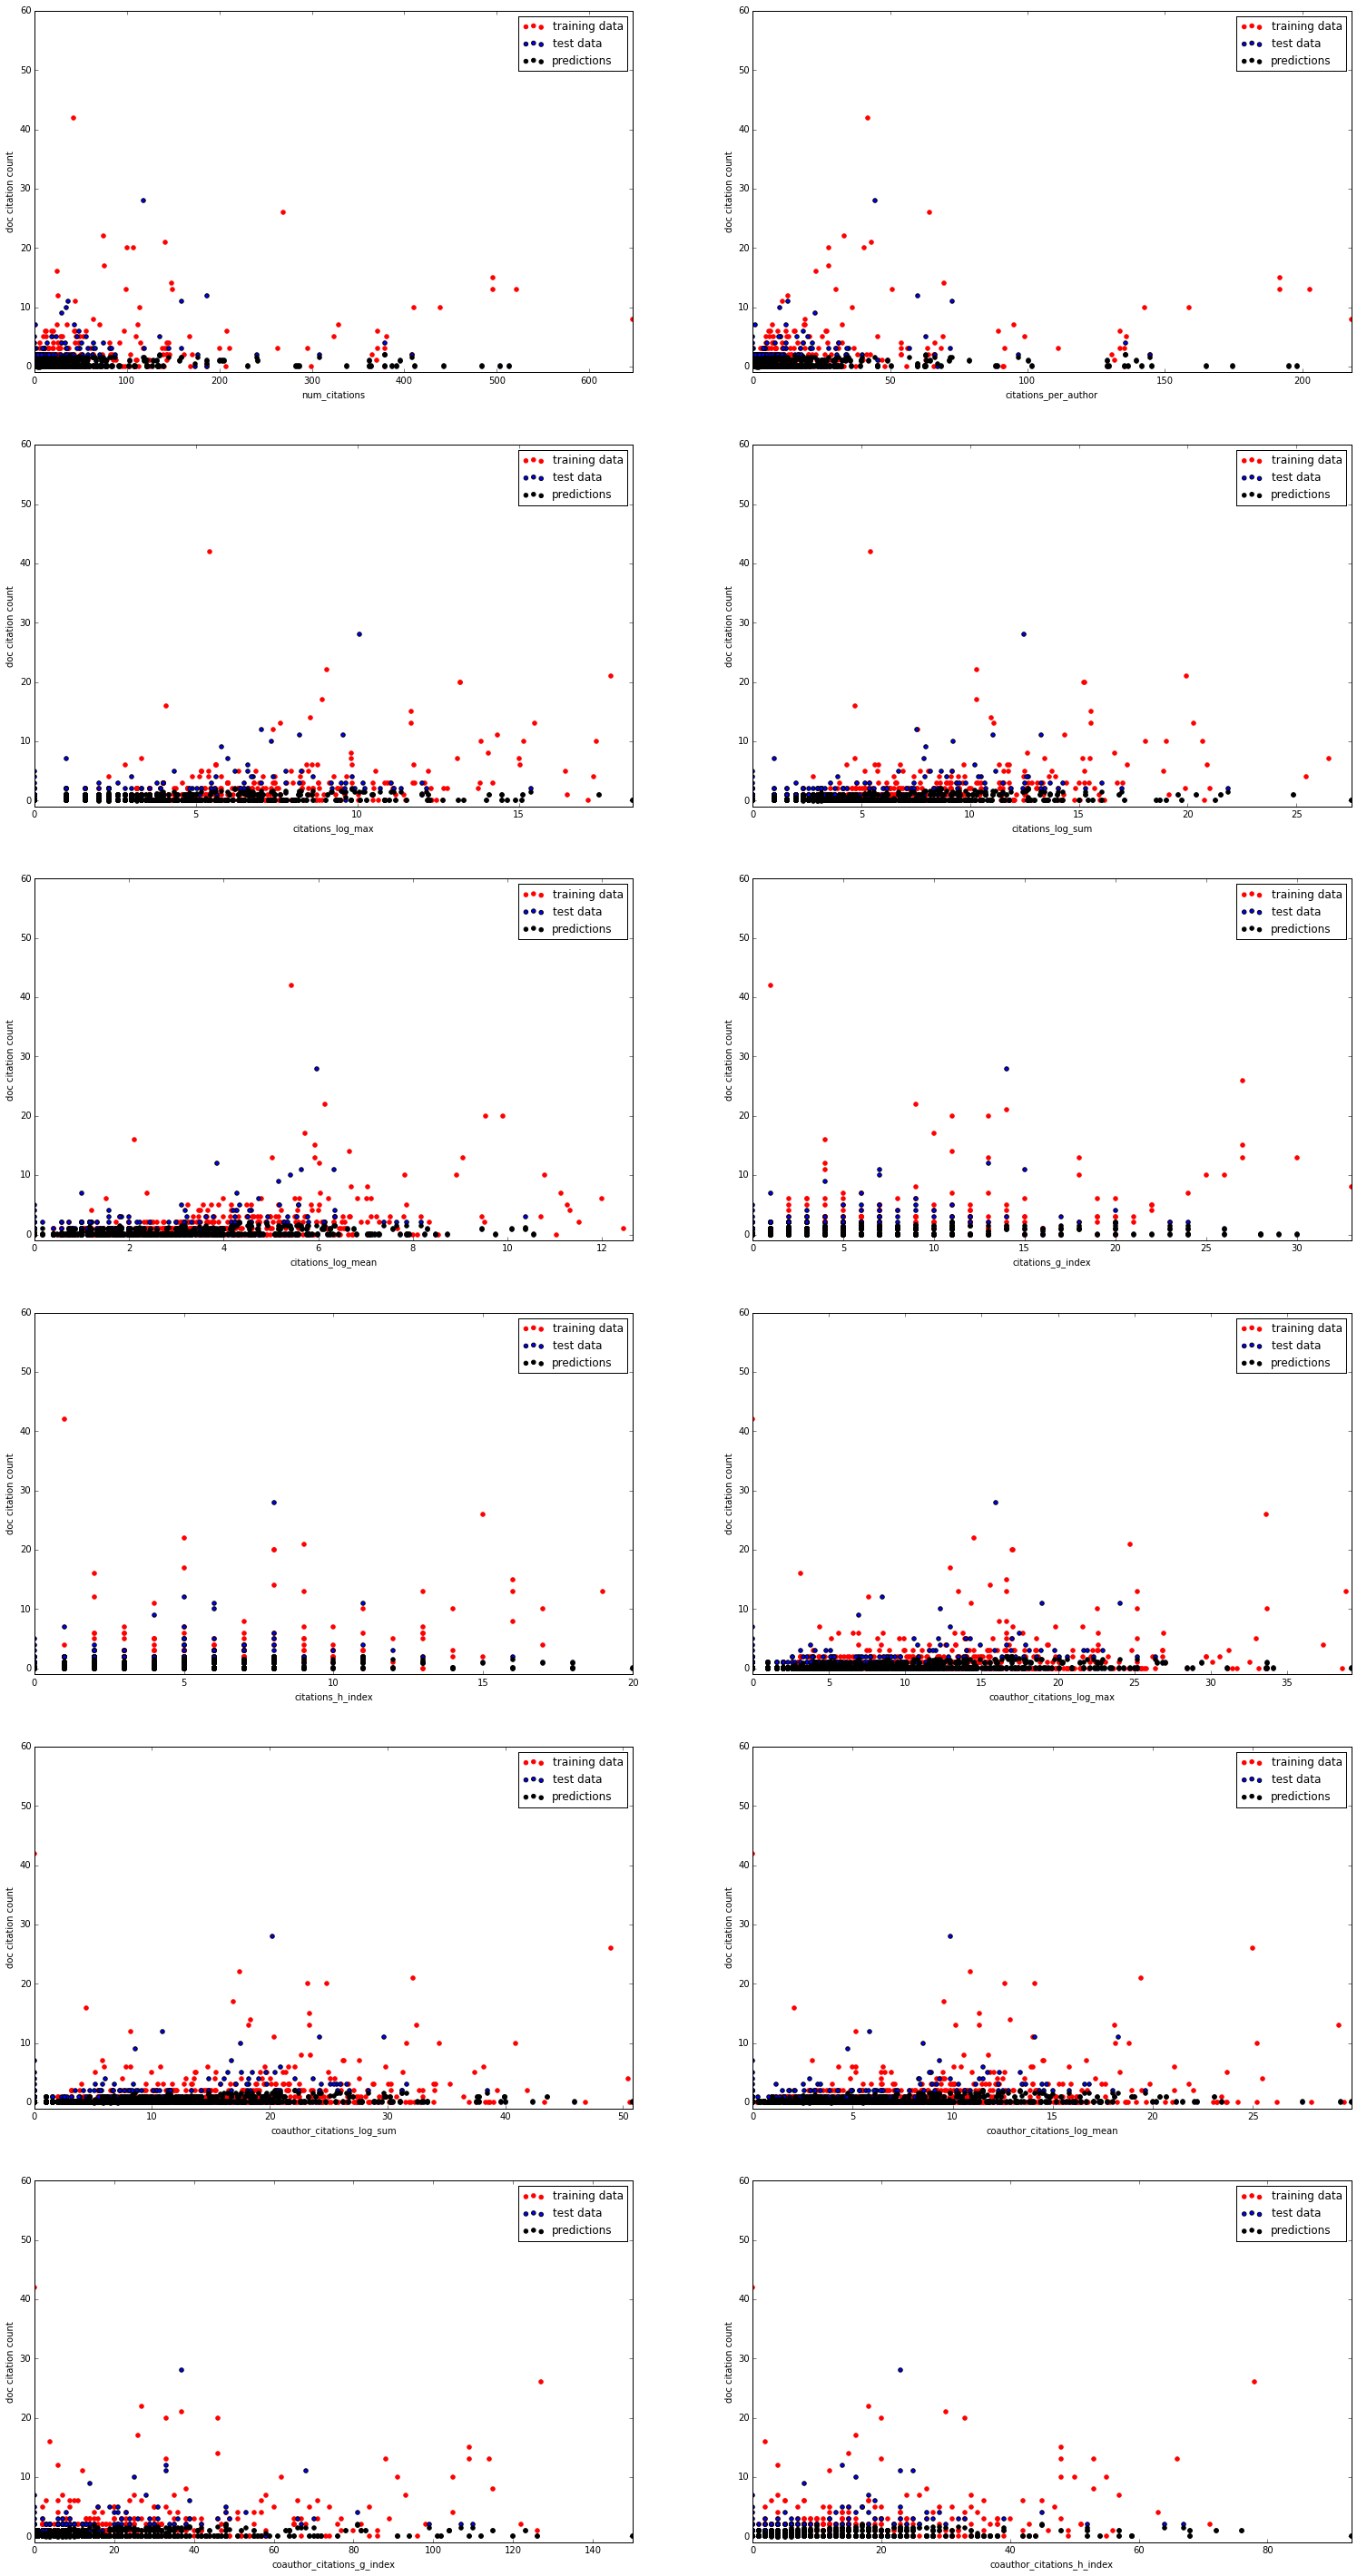

In [37]:
labels = [
    'num_citations',
    'citations_per_author',
    'citations_log_max',
    'citations_log_sum',
    'citations_log_mean',
    'citations_g_index',
    'citations_h_index',
    'coauthor_citations_log_max',
    'coauthor_citations_log_sum',
    'coauthor_citations_log_mean',
    'coauthor_citations_g_index',
    'coauthor_citations_h_index'
]

fig = plt.figure(figsize=(26,50))
for k in range(12):
    ax = fig.add_subplot(6, 2, k+1)
    plt.scatter(X_train_features[:1000, k], y_train[:1000], color='red')
    plt.scatter(X_test_features[:1000, k], y_test[:1000])
    plt.scatter(X_test_features[:1000, k], y_pred_svr[:1000], color='black')
    plt.xlabel(labels[k])
    plt.ylabel('doc citation count')
    plt.axis([min(X_test_features[:,k]), max(X_test_features[:,k]), -1, 60])
    plt.legend(['training data','test data','predictions'])
    #np.sum(X_test_features[:,0] == X_test_features[:,k])/float(X_test_features.shape[0])


# Methods to tokenize the text data

In [39]:


stemmer = PorterStemmer()
vectorizer = TfidfVectorizer(min_df=1)

def transform_word(word):
    return stemmer.stem(word.lower())

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    transformed_tokens = [transform_word(t) for t in tokens if len(t) > 1]
    return tokens

def get_tfidf_transform(corpus):
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    tfs = tfidf.fit_transform(corpus)
    return tfidf, tfs

## Example usage
#corpus = [papersAllYearsWithCitations.values()[i]['text'] for i in range(20)]
#tfidf, tfs = get_tfidf_transform(corpus[:10])
#result = tfidf.transform(corpus[10:])
#print result

In [43]:
papersAllYears = { p['title']: p for year in list(papersByYear) for p in papersByYear[year]['papers'].values() }
y = [len(p['citations']) for p in papersAllYears.values()]
X = [p['text'] for p in papersAllYears.values()]
corpus_train, corpus_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [44]:
y_true = y_test
tfidf, tfs_train = get_tfidf_transform(corpus_train)
tfs_test = tfidf.transform(corpus_test)

In [45]:
clf = LinearRegression()
clf.fit(tfs_train, np.log(np.array(y_train)+1))
y_pred = clf.predict(tfs_test)

In [46]:
clf = SVC()
clf.fit(tfs_train, y_train)
y_pred = clf.predict(tfs_test)

In [52]:
words_lr = LinearRegression()
words_lr.fit(tfs_train, y_train)
y_pred_words_lr = words_lr.predict(tfs_test)

In [47]:
words_svr = SVR()
words_svr.fit(tfs_train, y_train)
y_pred_words_svr = words_svr.predict(tfs_test)

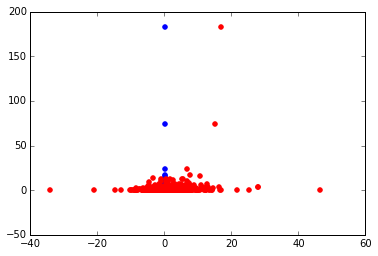

In [54]:
plt.scatter(y_pred_words_svr, y_test, color='blue')
plt.scatter(y_pred_words_lr, y_test, color='red')

In [53]:
print "LR:",  "r2:", r2_score(y_test, y_pred_words_lr),  "MSE:", np.mean(np.abs(y_test - y_pred_words_lr))
print "SVR:", "r2:", r2_score(y_test, y_pred_words_svr), "MSE:", np.mean(np.abs(y_test - y_pred_words_svr))

LR: r2: -0.208582828222 MSE: 4.40444219365
SVR: r2: -0.0358636069729 MSE: 1.75223467695


In [114]:
print confusion_matrix(y_true, y_pred)

[[341   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 47   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 24   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 12   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0

#Try clustering / outlier-detection: